In [27]:
conda install -c conda-forge skater

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\luish\anaconda3


  added / updated specs:
    - skater


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dill-0.3.6                 |     pyhd8ed1ab_1          81 KB  conda-forge
    ds-lime-0.1.1.27           |             py_1         214 KB  conda-forge
    multiprocess-0.70.14       |   py39haa95532_0         241 KB
    pathos-0.3.0               |     pyhd8ed1ab_0          51 KB  conda-forge
    pox-0.3.2                  |     pyhd8ed1ab_0          25 KB  conda-forge
    ppft-1.7.6.6               |     pyhd8ed1ab_0          32 KB  conda-forge
    skater-1.0.2               |py39hcbf5309_1003          68 KB  conda-forge
    ------------------------------------------------------------
                                        

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
#from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from mlxtend.classifier import StackingClassifier

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [2]:
redwine = pd.read_csv('redwine.csv', delimiter=';')
whitewine = pd.read_csv('whitewine.csv', delimiter=';')

In [3]:
redwine = redwine.drop_duplicates()
whitewine = whitewine.drop_duplicates()

#redwine = 0
redwine['wineType'] = 0

#whitewine = 1
whitewine['wineType'] = 1

wines_df = [redwine, whitewine]
wines = pd.concat(wines_df).reset_index()
wines = wines.drop(columns='index')

# DATA NORMALIZATION
wines_norm = wines.copy()

for column in wines_norm[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide',
                             'total sulfur dioxide','density','pH','sulphates','alcohol']].columns:
    wines_norm[column] = (wines_norm[column] -
                           wines_norm[column].mean()) / wines_norm[column].std()    


#DISCRETIZE QUALITY TO NOT NORMALIZED DATASET

wines_binary = wines.copy()

lst = []

for row in wines.quality:
    if row < 4:
        lst.append('low')
    elif row < 7:
        lst.append('medium')
    else:
        lst.append('high')

#0 = below average
#1 = above average

wines_binary['quality_binary'] = lst

#DISCRETIZE QUALITY TO NORMALIZED DATASET

wines_binary_norm = wines_norm.copy()

lst = []

for row in wines.quality:
    if row < 4:
        lst.append('low')
    elif row < 7:
        lst.append('medium')
    else:
        lst.append('high')

#0 = below average
#1 = above average

wines_binary_norm['quality_binary'] = lst

wines_binary_norm = wines_binary_norm.drop(columns='quality')
wines_binary = wines_binary.drop(columns='quality')

In [5]:
wines_binary_norm

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wineType,quality_binary
0,0.140051,2.115150,-2.164312,-0.699634,0.523831,-1.069172,-1.411010,1.100892,1.779136,0.177924,-0.969061,0,medium
1,0.443157,3.184998,-2.164312,-0.544084,1.120630,-0.282878,-0.829761,0.763681,-0.153783,0.979297,-0.631774,0,medium
2,0.443157,2.471766,-1.892494,-0.610748,0.957867,-0.844517,-1.058738,0.831124,0.220331,0.778954,-0.631774,0,medium
3,3.019557,-0.381161,1.641139,-0.699634,0.496704,-0.732189,-0.953056,1.168334,-0.403192,0.311486,-0.631774,0,medium
4,0.140051,1.877406,-2.164312,-0.721855,0.496704,-0.956844,-1.305329,1.100892,1.779136,0.177924,-0.969061,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,-0.769267,-0.797213,-0.193632,-0.766298,-0.479877,-0.339042,-0.389420,-1.144931,0.282683,-0.222763,0.548732,1,medium
5316,-0.466161,-0.143417,0.282049,0.655868,-0.262859,1.514366,0.949216,0.122981,-0.465544,-0.489887,-0.800417,1,medium
5317,-0.541937,-0.618905,-0.873177,-0.855183,-0.425622,-0.002059,-0.054761,-0.672836,-1.463179,-0.489887,-0.969061,1,medium
5318,-1.299702,-0.321725,-0.125677,-0.877404,-0.941040,-0.563697,-0.072375,-1.971097,0.719149,-1.024136,1.897880,1,high


In [4]:
def get_results(model, name, data, true_labels, target_names, results=None, reasume=False):

    if hasattr(model, 'layers'):
        param = wtp_dnn_model.history.params
        best = np.mean(wtp_dnn_model.history.history['val_acc'])
        predicted_labels = model.predict_classes(data) 
        im_model = InMemoryModel(model.predict, examples=data, target_names=target_names)

    else:
        param = gs.best_params_
        best = gs.best_score_
        predicted_labels = model.predict(data).ravel()
        if hasattr(model, 'predict_proba'):
            im_model = InMemoryModel(model.predict_proba, examples=data, target_names=target_names)
        elif hasattr(clf, 'decision_function'):
            im_model = InMemoryModel(model.decision_function, examples=data, target_names=target_names)
        
    print('Mean Best Accuracy: {:2.2%}'.format(best))
    print('-'*60)
    print('Best Parameters:')
    print(param)
    print('-'*60)
    
    y_pred = model.predict(data).ravel()
    
    display_model_performance_metrics(true_labels, predicted_labels = predicted_labels, target_names = target_names)
    if len(target_names)==2:
        ras = roc_auc_score(y_true=true_labels, y_score=y_pred)
    else:
        roc_auc_multiclass, ras = roc_auc_score_multiclass(y_true=true_labels, y_score=y_pred, target_names=target_names)
        print('\nROC AUC Score by Classes:\n',roc_auc_multiclass)
        print('-'*60)

    print('\n\n              ROC AUC Score: {:2.2%}'.format(ras))
    prob, score_roc, roc_auc = plot_model_roc_curve(model, data, true_labels, label_encoder=None, class_names=target_names)
    
    interpreter = Interpretation(data, feature_names=cols)
    plots = interpreter.feature_importance.plot_feature_importance(im_model, progressbar=False, ascending=True)
    
    r1 = pd.DataFrame([(prob, best, np.round(accuracy_score(true_labels, predicted_labels), 4), 
                         ras, roc_auc)], index = [name],
                         columns = ['Prob', 'CV Accuracy', 'Accuracy', 'ROC AUC Score', 'ROC Area'])
    if reasume:
        results = r1
    elif (name in results.index):        
        results.loc[[name], :] = r1
    else: 
        results = results.append(r1)
        
    return results

def roc_auc_score_multiclass(y_true, y_score, target_names, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(y_true)
  roc_auc_dict = {}
  mean_roc_auc = 0
  i = 0
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_y_true = [0 if x in other_class else 1 for x in y_true]
    new_y_score = [0 if x in other_class else 1 for x in y_score]
    num_new_y_true = sum(new_y_true)

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_y_true, new_y_score, average = average)
    roc_auc_dict[target_names[i]] = np.round(roc_auc, 4)
    mean_roc_auc += num_new_y_true * np.round(roc_auc, 4)
    i += 1
    
  mean_roc_auc = mean_roc_auc/len(y_true)  
  return roc_auc_dict, mean_roc_auc

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
                        

def train_predict_model(classifier,  train_features, train_labels,  test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, target_names):
    
    total_classes = len(target_names)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], target_names], codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], target_names], codes=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, target_names):

    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
   
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prb = clf.predict_proba(features)
            if prb.shape[1] > 1:
                y_score = prb[:, prb.shape[1]-1] 
            else:
                y_score = clf.predict(features).ravel()
            prob = True
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
            prob = False
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(true_labels, y_score)      
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label='ROC curve (area = {0:3.2%})'.format(roc_auc), linewidth=2.5)
        
    elif n_classes > 2:
        if  hasattr(clf, 'clfs_'):
            y_labels = label_binarize(true_labels, classes=list(range(len(class_labels))))
        else:
            y_labels = label_binarize(true_labels, classes=class_labels)
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
            prob = True
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
            prob = False
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
            
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_labels[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_labels.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:2.2%})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:2.2%})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_names):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:2.2%})'
                                           ''.format(label, roc_auc[i]), linewidth=2, linestyle=':')
        roc_auc = roc_auc["macro"]   
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return prob, y_score, roc_auc

In [5]:
class select_fetaures(object): # BaseEstimator, TransformerMixin, 
    def __init__(self, select_cols):
        self.select_cols_ = select_cols
    
    def fit(self, X, Y ):
        pass

    def transform(self, X):
        return X.loc[:, self.select_cols_]    

    def fit_transform(self, X, Y):
        self.fit(X, Y)
        df = self.transform(X)
        return df    

    def __getitem__(self, x):
        return self.X[x], self.Y[x]

In [6]:
wqp_class_labels = np.array(wines_binary['quality_binary'])
target_names = ['low','medium','high']
y = wines_binary.iloc[:, 12:13].values.ravel()

cols = wines_binary.columns
cols = list(cols.drop(['quality_binary']))
X_train, X_test, y_train, y_test = train_test_split(wines_binary.loc[:, cols], y, test_size=0.20, random_state=101)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Mean Best Accuracy: 82.73%
------------------------------------------------------------
Best Parameters:
{'clf__algorithm': 'ball_tree', 'clf__leaf_size': 1, 'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'distance'}
------------------------------------------------------------
Model Performance metrics:
------------------------------
Accuracy:  84.21% 
Precision: 82.03% 
Recall:    84.21% 
F1 Score:  82.46% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         low       0.66      0.41      0.51       198
      medium       0.00      0.00      0.00         9
        high       0.87      0.95      0.91       857

    accuracy                           0.84      1064
   macro avg       0.51      0.45      0.47      1064
weighted avg       0.82      0.84      0.82      1064


Prediction Confusion Matrix:
------------------------------
               

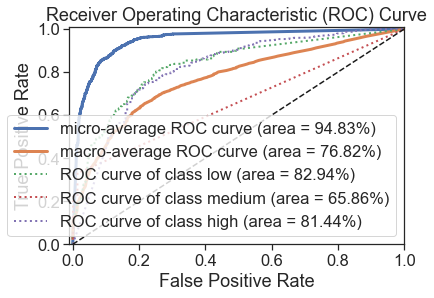

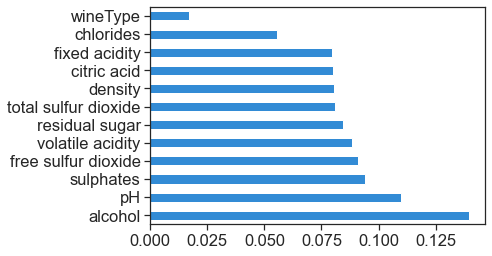

In [7]:
clf = Pipeline([
        #('pca', PCA(random_state = 101)),
        ('clf', KNeighborsClassifier())])

# a list of dictionaries to specify the parameters that we'd want to tune
SEL = cols
#n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]

param_grid =\
    [{'clf__n_neighbors': list(range(1,10,2)) 
     ,'clf__weights': ['distance'] 
     ,'clf__algorithm' : ['ball_tree', 'brute', 'auto', 'kd_tree'] #, 'brute', 'auto',  'kd_tree', 'brute']
     ,'clf__leaf_size': list(range(1,10,2))
     ,'clf__p': [1] 
     #,'pca__n_components' : n_components
     #,'pca__whiten' : whiten
     }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

KNNC = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

KNNC.fit(X_train,y_train)

results = get_results(KNNC, 'KNeighborsClassifier', X_test, y_test, 
                      target_names = target_names, reasume=True)